# Predicting the Margin of NFL Games using linear regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from clean3 import clean_games

In [2]:
# gather & pre-process our data (for details, see clean_game_data.ipynb and clean3.py)
df = clean_games('data/games.pickle', start_year=1990)

/Users/ewilens/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [3]:
game_df = df.copy() # to prevent needing to rerun clean_games

Let's start by dropping games where the margin > +/- 50 points. These are outliers, and should not be predicted.

In [4]:
mask = (game_df.margin < 50) & (game_df.margin > -50)
game_df = game_df[mask]

In [5]:
# game_df = game_df.dropna(subset=['trend_ewma4_19_opp', 'trend_ewma4_19'], how='any')
# game_df[['trend_ewma4_19_opp', 'trend_ewma4_19']] = game_df[['trend_ewma4_19_opp', 'trend_ewma4_19']].astype(float)


## Feature Selection

See `feature_engineering.ipynb` for more information about the feature selection process.

In [6]:
features = [
    'season_year',
    'team_home_game',
    'ewma_team_home_game',
    'ewma_team_home_game_opp',
    'ewma10_margin',
    'ewma10_wins_opp',
    'roll19_wins',
    'roll19_margin_opp',
    'ewma_margin_opp',
    'ewma_margin',
    'ewma_pass_yds_def',
    'ewma_total_yds_def',
    'ewma_total_yds_def_opp',
    'ewma_result_win_opp',
    'ewma_third_conv_pct',
    'ewma_third_conv_pct_opp',
    'ewma_pass_cmp_perc_def', 
    'ewma_pass_cmp_perc_def_opp', 
    'trend_ewma4_19',
    'trend_ewma4_19_opp',
]

target = 'margin'

print("Number of Features: ", len(features))

Number of Features:  20


In [7]:
all_cols = [c for c in features]
all_cols.append('margin')
model_df = game_df[all_cols]

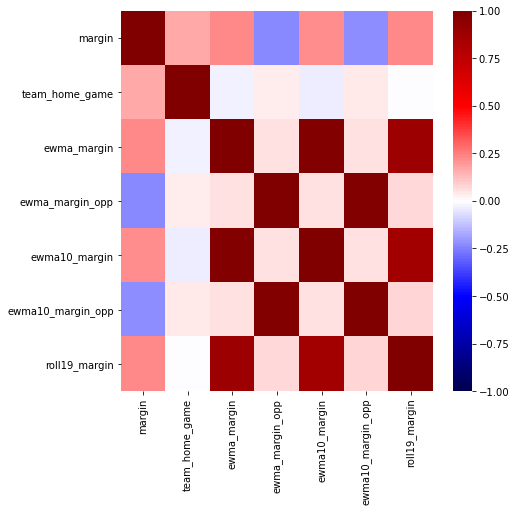

In [8]:
pres_plot_cols = ['margin', 'team_home_game', 'ewma_margin', 'ewma_margin_opp', 'ewma10_margin', 
                  'ewma10_margin_opp', 'roll19_margin']

pres_data = game_df[pres_plot_cols]

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(pres_data.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

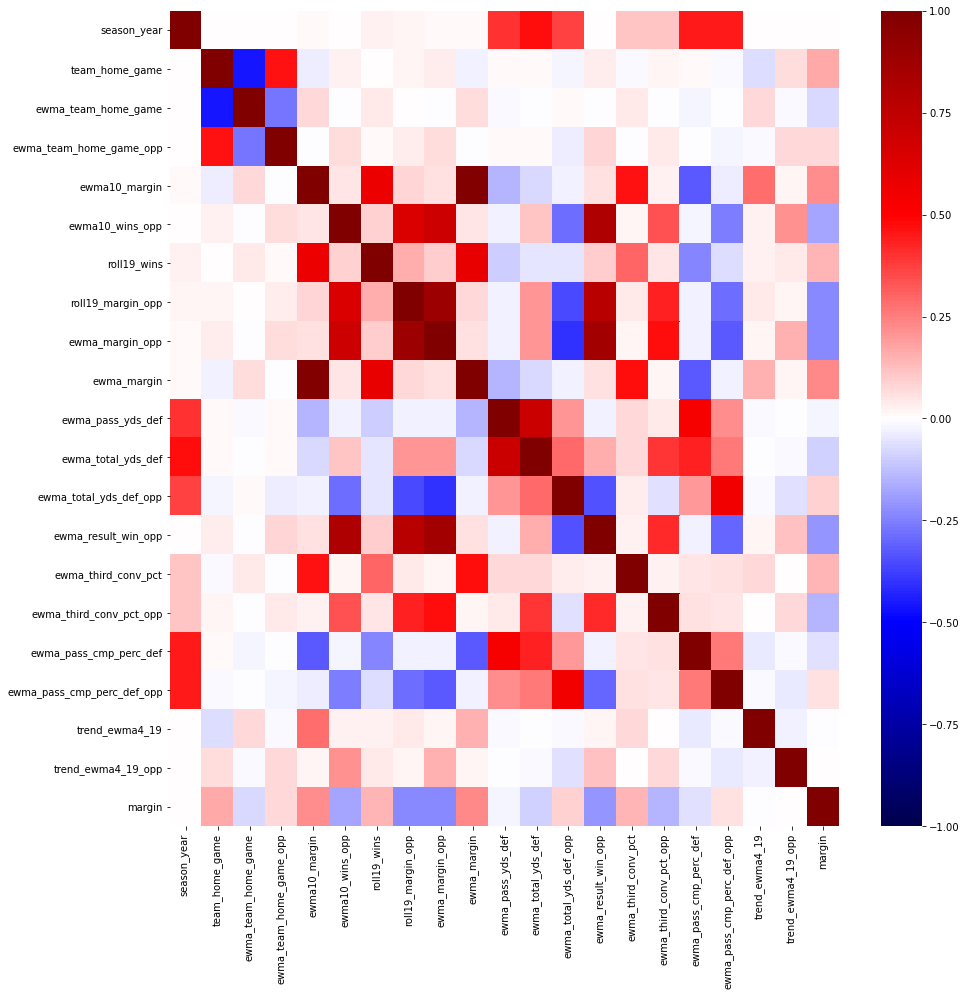

In [9]:

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(game_df[all_cols].corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [10]:
game_df.reindex()

,game_id,season_year,week_num,team_year,full_game_date,team,decade,opp,game_day_of_week,game_outcome,...,ewma_third_conv_pct,ewma_third_conv_pct_def,ewma_third_conv_pct_opp,ewma_third_conv_pct_def_opp,ewma_total_yds_off,ewma_total_yds_def,ewma_total_yds_off_opp,ewma_total_yds_def_opp,trend_ewma4_19,trend_ewma4_19_opp
3,atl-rai-1991-09-22,1991,4.0,atl-1991,1991-09-22,atl,199,rai,Sun,W,...,0.414545,0.236831,0.444372,0.384148,196.465,311.192,275.041,317.376,1.513,6.066
4,atl-nor-1991-09-29,1991,5.0,atl-1991,1991-09-29,atl,199,nor,Sun,L,...,0.415208,0.267617,0.323996,0.201953,209.705,302.268,299.874,213.147,1.619,3.706
5,atl-sfo-1991-10-13,1991,7.0,atl-1991,1991-10-13,atl,199,sfo,Sun,W,...,0.366330,0.333438,0.406125,0.399926,189.997,392.980,368.613,283.708,-2.404,-1.918
6,atl-crd-1991-10-20,1991,8.0,atl-1991,1991-10-20,atl,199,crd,Sun,L,...,0.383877,0.390719,0.391666,0.405214,194.481,390.020,288.207,332.186,0.335,-6.537
7,atl-ram-1991-10-27,1991,9.0,atl-1991,1991-10-27,atl,199,ram,Sun,W,...,0.359075,0.395877,0.382289,0.348152,197.839,367.537,279.497,325.905,-0.155,2.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14773,sfo-was-2020-12-13,2020,14.0,was-2020,2020-12-13,was,202,sfo,Sun,W,...,0.384705,0.372204,0.407858,0.375742,231.228,469.164,363.062,332.646,6.850,-3.700
14774,sea-was-2020-12-20,2020,15.0,was-2020,2020-12-20,was,202,sea,Sun,L,...,0.357849,0.356448,0.407098,0.447129,212.962,466.936,377.980,353.975,5.199,8.691
14775,car-was-2020-12-27,2020,16.0,was-2020,2020-12-27,was,202,car,Sun,L,...,0.393466,0.363534,0.386004,0.478944,220.358,444.073,352.371,356.069,0.341,-1.290
14776,phi-was-2021-01-03,2020,17.0,was-2020,2021-01-03,was,202,phi,Sun,W,...,0.403107,0.368655,0.357061,0.372796,227.742,418.340,355.867,390.934,-2.443,-4.910


In [11]:
X = model_df[features]
y = game_df[target]

## Rigorous Cross-Validation Using Manual K-Fold

I will be using an 80/20 Train/Test split. Note that despite all of the cross-validation we completed in `feature_selection.ipynb`, we still have yet to predict `y_test` using `X_test` data.

The reason we haven't yet used our test set is to prevent overfitting. By holding these out and engineering the features we're including in our model, we should avoid **overfitting**. This would result in our model recognizing outliers as patterns and ultimately the inability to generalize to fresh inputs.

In [12]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, lars_path
from sklearn.metrics import mean_squared_error, mean_absolute_error

def cross_validate_lr(X, y):
    '''
        Performs K-Fold cross-validation on linear regression model and computes model metrics

        Features are scaled using standard scaler.

        ------------------
        Parameters:

        - X: DataFrame or numpy array of features/independent variables from training set
        - y: DataFrame or numpy array of target/dependent variable from training set

        ------------------
        Returns:
        
        - model

        Model metrics with cross-validation: R^2 score for training and validation sets
        with each fold, mean R^2 score for validation set across all folds;
        mean training/validation score ratios, MAE, RMSE across all folds
    '''
    
    train_results = []
    val_results = []
    ratios = []
    maes = []
    rmses = []
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)   # default values
    
    
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):
        
        
        # iterate thru 5 shuffled train/validation sets & collect results
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        
        # standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_val_scaled = scaler.transform(X_val.values)
        X_test_scaled = scaler.transform(X_test.values) # scaling test set now
        
        # fit linear model to the standardized train dataset
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # validate
        y_pred = model.predict(X_val)
        
        # store results
        train_results.append(model.score(X_train_scaled, y_train))
        val_results.append(model.score(X_val_scaled, y_val))
        ratios.append(model.score(X_train_scaled, y_train) / model.score(X_val_scaled, y_val))
        maes.append(mean_absolute_error(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
    # summarize results    
    print('Linear regression train R^2:', train_results)
    print('-----------')
    print('Linear regression val R^2: \n ', val_results)
    print('-----------')
    print(f'Linear regression mean val R^2: {np.mean(val_results):.3f} +- {np.std(val_results):.3f}')
    print('-----------')
    print(f'Mean train/val R^2 ratio: {np.mean(ratios):.3f} +- {np.std(ratios):.3f}')
    print('-----------')
    print('Mean MAE: ', np.mean(maes))
    print('-----------')
    print('Mean RMSE: ', np.mean(rmses))
    
    return model, X_test_scaled, y_test, scaler

## Testing Results

In [13]:
model, X_test_scaled, y_test, scaler = cross_validate_lr(X, y)

Linear regression train R^2: [0.16368739544507172, 0.1589269558663362, 0.15448080350680649, 0.15633673740483323, 0.1564691378230929]
-----------
Linear regression val R^2: 
  [0.1308460907058686, 0.1491357611421944, 0.16799681350940032, 0.1605789532365679, 0.15852335983595733]
-----------
Linear regression mean val R^2: 0.153 +- 0.013
-----------
Mean train/val R^2 ratio: 1.039 +- 0.116
-----------
Mean MAE:  160.54152165790939
-----------
Mean RMSE:  197.08868862733235


In [14]:
model.score(X_test_scaled, y_test)

0.1501581640381231

In [15]:
model.intercept_

0.11350856545050285

Not bad! The model generalized well - less than 0.15 lower than our mean cross-validation $R^2$. 

Let's take a look at our features and their corresponding slopes/coefficients

In [16]:
for feature, coef in zip(features, model.coef_):
    print(feature, ': ', coef)

season_year :  0.15175968114098137
team_home_game :  2.70749989435584
ewma_team_home_game :  -0.2251741532126227
ewma_team_home_game_opp :  0.18754383203093847
ewma10_margin :  -2.2604760046932637
ewma10_wins_opp :  -0.3286231169378926
roll19_wins :  0.6258443922996477
roll19_margin_opp :  -2.0442706438424483
ewma_margin_opp :  -1.241420758031388
ewma_margin :  5.1134482346064365
ewma_pass_yds_def :  0.28629643665612564
ewma_total_yds_def :  -0.4182779756761317
ewma_total_yds_def_opp :  0.10939245370304218
ewma_result_win_opp :  -0.08527434788396482
ewma_third_conv_pct :  0.5009176286129575
ewma_third_conv_pct_opp :  -0.5977150970222419
ewma_pass_cmp_perc_def :  0.02338183309382294
ewma_pass_cmp_perc_def_opp :  -0.07770642563618083
trend_ewma4_19 :  0.037048828746071176
trend_ewma4_19_opp :  0.11639769484697114


In [17]:
test_coefs = {}
for feature, coef in zip(features, model.coef_):
    test_coefs[feature] = coef

bar_df = pd.DataFrame(features, columns=['feature'])
bar_df['slope'] = list(model.coef_)
bar_df['abs_val_slope'] = abs(bar_df.slope)
bar_df.sort_values('abs_val_slope', ascending=False, inplace=True)
bar_df = bar_df[['feature', 'slope']]
bar_df

,feature,slope
9,ewma_margin,5.113448
1,team_home_game,2.707500
4,ewma10_margin,-2.260476
7,roll19_margin_opp,-2.044271
8,ewma_margin_opp,-1.241421
6,roll19_wins,0.625844
15,ewma_third_conv_pct_opp,-0.597715
14,ewma_third_conv_pct,0.500918
11,ewma_total_yds_def,-0.418278
5,ewma10_wins_opp,-0.328623


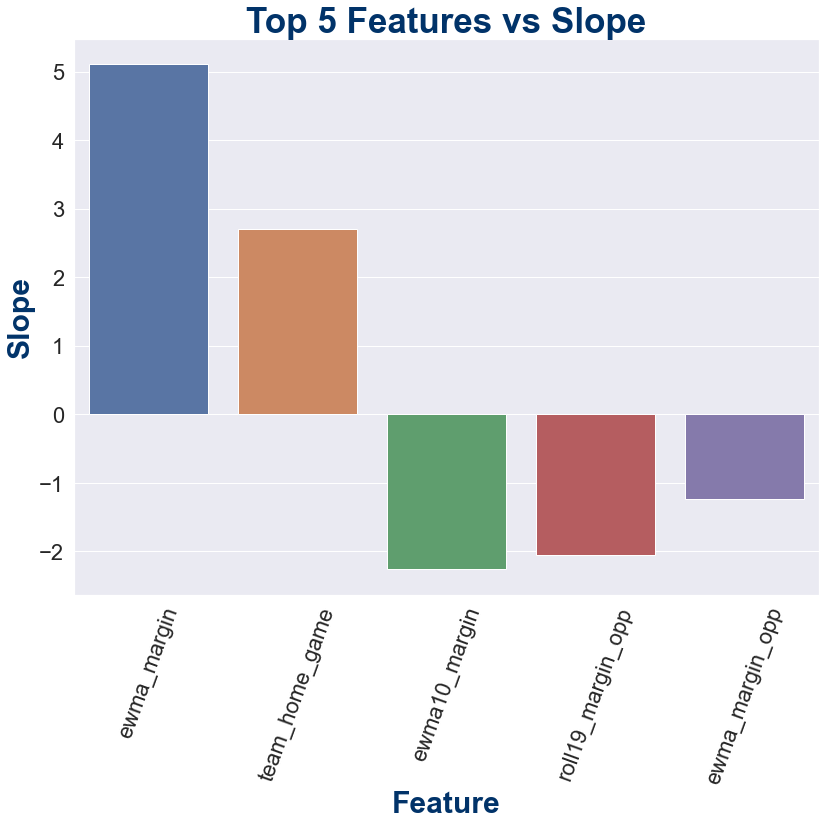

In [39]:
#run entire NB, then re-run this cell.
sns.set(font_scale=2)
top_five = bar_df.iloc[0:5]

nfl_red = '#D50A0A'
nfl_blue = '#013369'
ax = sns.barplot(x=top_five.feature, y=top_five.slope)
ax.set_xlabel("Feature", fontsize=30, weight='bold', color=nfl_blue)
ax.set_ylabel("Slope", fontsize=30, weight='bold', color=nfl_blue)
ax.set_title("Top 5 Features vs Slope", fontsize=35, weight='bold', color=nfl_blue)
ax.set_xticklabels(labels=top_five['feature'], rotation=70)
ax.legend=True
ax.grid=True
plt.tight_layout()
plt.savefig("figures/features_vs_slope.png")

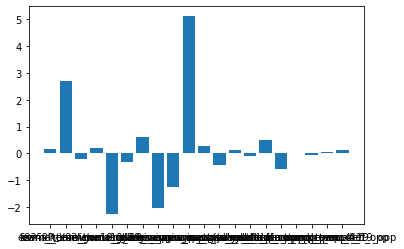

In [19]:
plt.bar(features, model.coef_)
plt.xlabels=None

In [20]:
model.coef_

array([ 0.15175968,  2.70749989, -0.22517415,  0.18754383, -2.260476  ,
       -0.32862312,  0.62584439, -2.04427064, -1.24142076,  5.11344823,
        0.28629644, -0.41827798,  0.10939245, -0.08527435,  0.50091763,
       -0.5977151 ,  0.02338183, -0.07770643,  0.03704883,  0.11639769])

## Plotting Results

In [21]:
model
test_df = pd.DataFrame(X_test_scaled)
test_df.columns = features

test_features = test_df[features].to_numpy()

predictions = model.predict(test_features)

# transform scaled features back to orignal
test_df[features] = scaler.inverse_transform(test_df[features].to_numpy())
test_df['prediction'] = predictions



test_df['actual'] = list(y_test)
test_df['resid'] = test_df['prediction'] - test_df['actual']


test_df

,season_year,team_home_game,ewma_team_home_game,ewma_team_home_game_opp,ewma10_margin,ewma10_wins_opp,roll19_wins,roll19_margin_opp,ewma_margin_opp,ewma_margin,...,ewma_result_win_opp,ewma_third_conv_pct,ewma_third_conv_pct_opp,ewma_pass_cmp_perc_def,ewma_pass_cmp_perc_def_opp,trend_ewma4_19,trend_ewma4_19_opp,prediction,actual,resid
0,1999.0,1.0,0.473,0.509,2.0,1.0,4.0,22.0,3.135,1.660,...,0.844,0.451690,0.355506,55.789,53.137,0.340,-1.135,2.206819,-7.0,9.206819
1,2019.0,1.0,0.526,0.600,-3.0,0.0,2.0,-55.0,-7.926,-2.558,...,0.265,0.384187,0.383441,59.401,68.445,-2.442,-1.074,5.454553,5.0,0.454553
2,2001.0,0.0,0.573,0.546,5.0,0.0,7.0,-46.0,-5.238,6.270,...,0.476,0.377196,0.448971,62.441,61.935,-3.270,0.238,2.692565,7.0,-4.307435
3,1991.0,0.0,0.526,0.486,-12.0,1.0,2.0,41.0,3.778,-11.734,...,0.672,0.326797,0.440417,58.887,52.377,1.734,1.222,-11.141008,-27.0,15.858992
4,2008.0,1.0,0.299,0.668,-3.0,0.0,1.0,16.0,6.081,-3.458,...,0.369,0.262792,0.556087,56.251,66.480,2.458,2.919,-2.455613,-10.0,7.544387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2385,2016.0,1.0,0.467,0.554,-2.0,1.0,3.0,21.0,3.012,-3.744,...,0.564,0.383383,0.460985,60.478,63.571,4.744,8.988,-1.270411,-3.0,1.729589
2386,2003.0,0.0,0.631,0.332,22.0,1.0,3.0,15.0,6.129,21.192,...,0.701,0.466754,0.300344,58.982,59.343,1.808,3.871,5.082260,7.0,-1.917740
2387,1997.0,1.0,0.542,0.478,3.0,0.0,5.0,19.0,1.367,4.320,...,0.488,0.412526,0.417268,58.246,62.568,-2.320,-2.367,3.917637,3.0,0.917637
2388,2015.0,1.0,0.397,0.483,-3.0,0.0,3.0,7.0,0.415,-3.785,...,0.505,0.402994,0.364915,71.126,67.642,3.785,-1.415,1.620695,-14.0,15.620695


In [22]:
def jitter(values, jitter=0.5):
    """ Adds randomized noise to actual margins to account for our predictions =
        being floats (not int). This will help visualize results in the scatterplot
        below. 
    """
    n = len(values)
    return np.random.uniform(-jitter, + jitter, n) + values

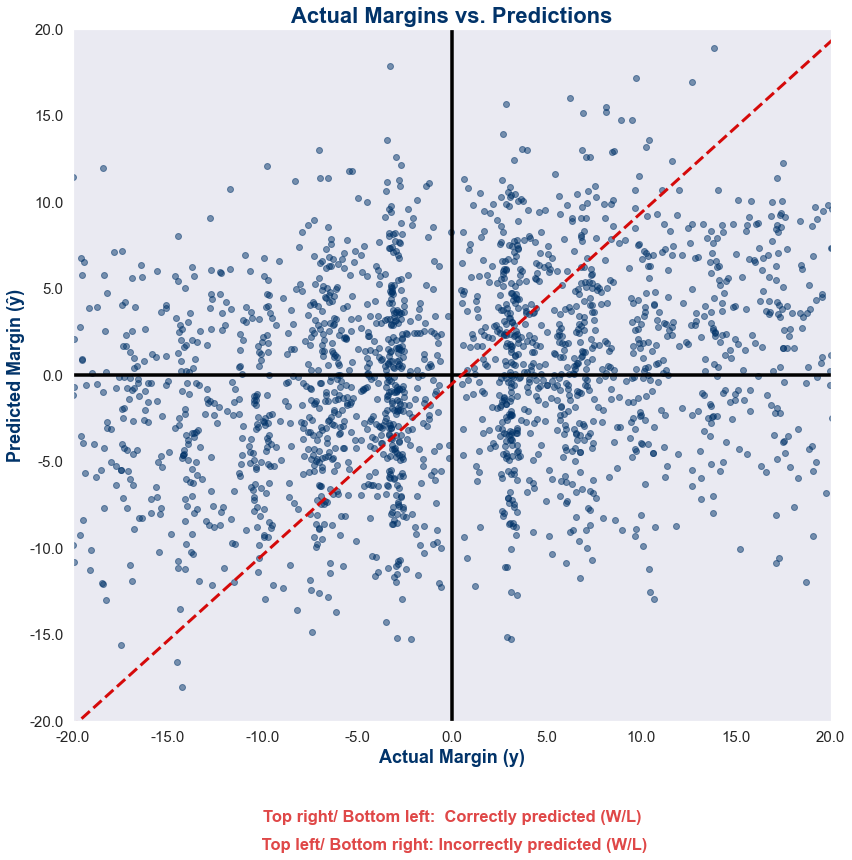

In [30]:
# plot actuals vs predictions

sns.set(rc={'figure.figsize':(12, 12)})
sns.set_style("dark", {'axes.grid': False})
fig, ax = plt.subplots()
ax.scatter(jitter(test_df['actual']), test_df['prediction'], c='#013369', alpha=0.5)

# set x/y labels
ax.set_xlabel('Actual Margin (y)', fontsize=18, weight='bold', c='#013369')
ax.set_ylabel('Predicted Margin (ŷ)', fontsize=18, weight='bold', c='#013369')

# add custom-placed 
title = "Actual Margins vs. Predictions"
subtitle_1 = "Top right/ Bottom left:  Correctly predicted (W/L)"
subtitle_2 = " Top left/ Bottom right: Incorrectly predicted (W/L)"

ax.set_title(title, fontsize=22, weight=900, c='#013369')

ax.text(x=.5, y=-0.15, s=subtitle_1, fontsize=16.5, weight='black',color='#D50A0A',
        alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

ax.text(x=.5, y=-0.19, s=subtitle_2, fontsize=16.5, weight='black',color='#D50A0A',
        alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)


# fix tick label sizes & values
ticks = list(np.linspace(-20, 20, 9))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks, size=15)
ax.set_xticklabels(ticks, size=15)

ax.grid=False # removes gridlines

# plot quadrant lines
plt.axvline(x=0, color='black', lw=3.5)
plt.axhline(y=0, color='black', lw=3.5)
plt.xlim((-20, 20))
plt.ylim((-20, 20))
plt.tight_layout()

ax.plot([y.min(), y.max()], [test_df['actual'].min(), test_df['actual'].max()],
        'k--', lw=3, color='#D50A0A')
plt.savefig('figures/pred_vs_actual.png')
plt.show()

In [41]:
test_df['predicted_w_l'] = (test_df.prediction > 0) & (test_df.actual > 0)

In [42]:
mask = test_df.predicted_w_l == True
test_df.shape, test_df[mask].shape

((2390, 24), (771, 24))

In [44]:
test_df[['season_year', 'prediction', 'actual', 'predicted_w_l']]

,season_year,prediction,actual,predicted_w_l
0,1999.0,2.206819,-7.0,False
1,2019.0,5.454553,5.0,True
2,2001.0,2.692565,7.0,True
3,1991.0,-11.141008,-27.0,False
4,2008.0,-2.455613,-10.0,False
...,...,...,...,...
2385,2016.0,-1.270411,-3.0,False
2386,2003.0,5.082260,7.0,True
2387,1997.0,3.917637,3.0,True
2388,2015.0,1.620695,-14.0,False


In [51]:
np.std(test_df.resid.to_numpy())

13.580263349415167

In [52]:
np.std(test_df.prediction.to_numpy())

5.943836637647464

In [53]:
np.std(test_df.actual.to_numpy())

14.732308812709213

(array([  37.,  267.,  852., 1708., 3102., 3118., 1708.,  852.,  267.,
          37.]),
 array([-49. , -39.2, -29.4, -19.6,  -9.8,   0. ,   9.8,  19.6,  29.4,
         39.2,  49. ]),
 <BarContainer object of 10 artists>)

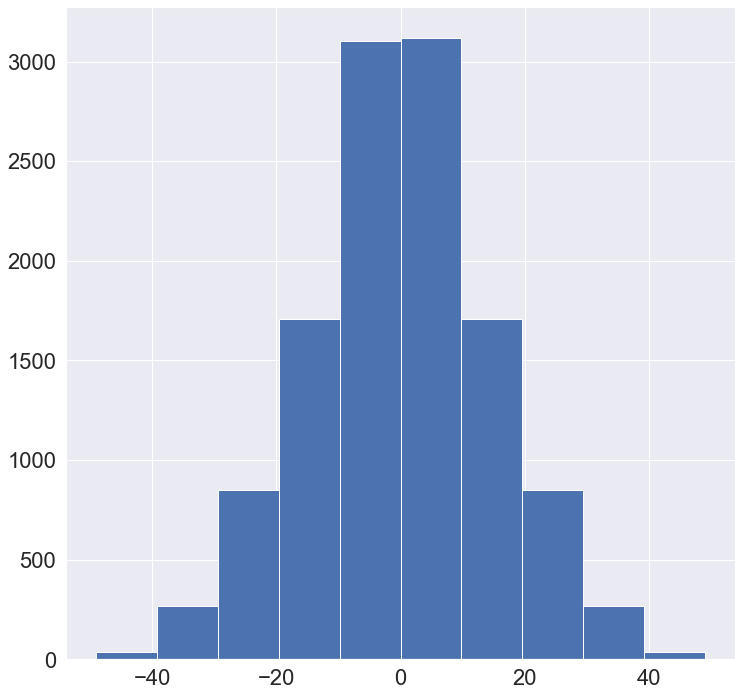

In [55]:
plt.hist(game_df.margin)